In [1]:
import os
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from facenet_pytorch import InceptionResnetV1

C:\Users\sirifris\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


In [2]:
# Paths
data_dir = 'D:\\Images\\Training_images\\data'  # Labeled training data
output_dir = 'D:\\Images\\Covid\\output_images_detected'  # Unlabeled test data

Displaying one random image from Jonas Gahr Støre: Jonas Gahr Støre_272.jpg


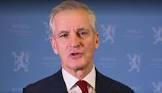

Displaying one random image from Erna Solberg: Erna Solberg_458.jpg


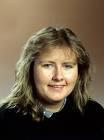

Displaying one random image from Bent Høie: Bent Høie_419.jpg


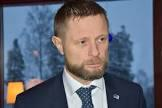

Displaying one random image from Lan Marie Berg: Lan Marie Berg_561.jpg


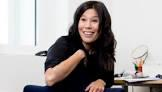

Displaying one random image from Sylvi Lysthaug: Sylvi Lysthaug_33.jpg


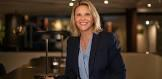

Displaying one random image from Espen Rostrup Nakstad: Espen Rostrup Nakstad_14.jpg


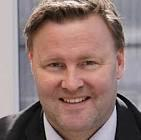

Displaying one random image from Trygve Slagsvold Vedum: Trygve Slagsvold Vedum_86.jpg


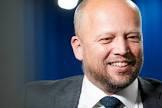

Displaying one random image from Camilla Stoltenberg: Camilla Stoltenberg_410.jpg


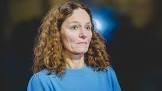

Displaying one random image from Fredrik Solvang: Fredrik Solvang_492.jpg


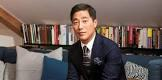

Displaying one random image from Donald Trump: Donald Trump_528.jpg


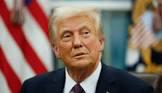

Displaying one random image from Joe Biden: Joe Biden_200.jpg


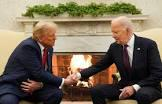

Displaying one random image from Anthony Fauci: Anthony Fauci_9.jpg


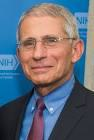

Displaying one random image from Bill Gates: Bill Gates_57.jpg


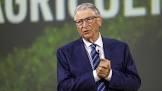

Displaying one random image from Random People Walking: Random People Walking_607.jpg


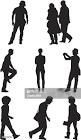

Displaying one random image from random people: random people_545.jpg


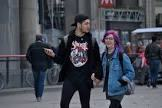

Displaying one random image from random facebook post: random facebook post_388.jpg


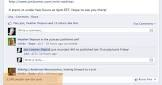

Displaying one random image from random twitter post: random twitter post_554.jpg


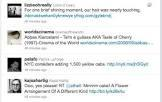

In [14]:
import random
from PIL import Image

subfolders = [f.name for f in os.scandir(data_dir) if f.is_dir()]

# Iterate over each subfolder (each species)
for subfolder in subfolders:
    subfolder_path = os.path.join(data_dir, subfolder)

    # Get a list of all image files in the subfolder
    images = [f for f in os.listdir(subfolder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Select a random image from the subfolder
    random_image = random.choice(images)

    # Full path to the selected image
    image_path = os.path.join(subfolder_path, random_image)

    # Open and display the image<
    image = Image.open(image_path)
    print(f"Displaying one random image from {subfolder}: {random_image}")
    display(image)

In [3]:
class_names = [
    'Jonas Gahr Støre',
    'Erna Solberg', 
    'Bent Høie',
    'Lan Marie Berg',
    'Sylvi Lysthaug',
    'Espen Rostrup Nakstad',
    'Trygve Slagsvold Vedum',
    'Camilla Stoltenberg',
    'Fredrik Solvang',
    'Donald Trump',
    'Joe Biden',
    'Anthony Fauci',
    'Bill Gates',
    'Random People Walking',
    'random people',
    'random facebook post',
    'random twitter post'
]

In [9]:
transform = transforms.Compose([
    transforms.Resize((160,160)), # resize all images 
    transforms.RandomHorizontalFlip(), # randomly flip horizontally...
    transforms.RandomVerticalFlip(), # ... and vertically ...
    transforms.RandomRotation(30), # ... and rotate
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [20]:
# Load training data
train_data = datasets.ImageFolder(data_dir, transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, num_workers=2) # Change if on GPU, batch=32

In [ ]:
# Model: Pretrained FaceNet
model = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=len(class_names)).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Using a scheduler to adjust the learning rate dynamically
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}')

In [ ]:
from pathlib import Path

for class_name in class_names:
    class_folder = Path(output_dir) / class_name
    class_folder.mkdir(parents=True, exist_ok=True)

In [ ]:
# Load unlabeled test images
test_images = [os.path.join(output_dir, img) for img in os.listdir(output_dir)]
model.eval()

def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    return class_names[predicted.item()]

In [ ]:
import shutil

for test_image in test_images:
    try:
        image = Image.open(test_image).convert('RGB')
        input_tensor = transform(image).unsqueeze(0)

        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)

        predicted_class = class_names[predicted.item()]

        target_folder = Path(output_dir) / predicted_class

        shutil.copy(test_image, target_folder)

    except Exception as e:
        print(f"Error processing {test_image}: {e}")

print(f"All images have been classified")